In [1]:
import pandas as pd
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.gaussian_process import GaussianProcess
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 

2022-05-24 19:56:55.500663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 19:56:55.500744: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:
n = 30 
N = int(n**2) ## sample size
M = 1 ## Number of replicate
coord1 = np.linspace(0,1,n)
coord2 = np.linspace(0,1,n)
P = 1
X = np.array([np.ones(N)]).T
s1,s2 = np.meshgrid(coord1,coord2)
s = np.vstack((s1.flatten(),s2.flatten())).T
y = np.sin(30*((s[:,0]+s[:,1])/2-0.9)**4)*np.cos(2*((s[:,0]+s[:,1])/2-0.9))+((s[:,0]+s[:,1])/2-0.9)/2

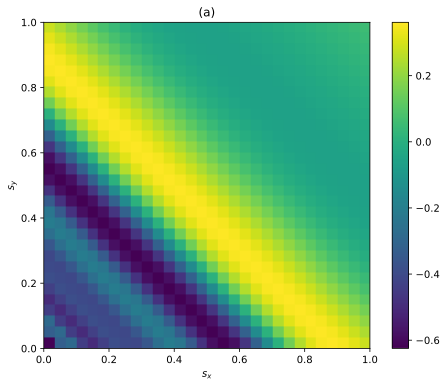

In [3]:
##Visualization
y_mat = y.reshape(n,n)
fig, ax = plt.subplots()
im = ax.imshow(y_mat , extent=[0, 1, 0, 1], origin="lower",
               vmax=y_mat .max(), vmin=y_mat .min())
plt.xlabel('$s_x$')
plt.ylabel('$s_y$')
plt.title('(a)')
plt.colorbar(im)
#plt.show()
plt.savefig("nonstat_fun_2d.pdf")

In [4]:
num_basis = [10**2,19**2,37**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
K = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

In [5]:
tf.keras.metrics.MeanAbsolutePercentageError(
    name="mean_absolute_percentage_error", dtype=None
)

def deep_model(model, X_train, y_train, X_valid, y_valid, data_type):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    #sgd = optimizers.gradient_descent_v2.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    if data_type == 'continuous':
        model.compile(optimizer='adam'
                      , loss='mse'
                      , metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])
    if data_type == 'discrete':
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results_test = model.evaluate(X_test, y_test, verbose=0)
    results_train = model.evaluate(X_train, y_train, verbose=0)
    return results_test, results_train
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    return min_epoch



2022-05-24 19:57:06.034589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 19:57:06.034681: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 19:57:06.034734: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thinkpad): /proc/driver/nvidia/version does not exist
2022-05-24 19:57:06.035787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# DeepKriging model for continuous data with 4 hidden layers
model_4 = Sequential()
model_4.add(Dense(100, input_dim = K,  kernel_initializer='he_uniform', activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(1, activation='linear'))

NameError: name 'model_base' is not defined

In [ ]:
# Baseline DNN only with coordinates
# Neural network
model_base = Sequential()
model_base.add(Dense(100, input_dim=2,  kernel_initializer='he_uniform', activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_base.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(Dense(100, activation='relu'))
model_base.add(BatchNormalization())
model_base.add(Dense(1, activation='linear'))

In [7]:
from sklearn.model_selection import KFold
NB_START_EPOCHS = 200  # Number of epochs we usually start to train with
BATCH_SIZE = 64  # Size of the batches used in the mini-batch gradient descent

In [8]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 123)
fold_no = 1
inputs = phi
inputs_base = s
targets = y

In [21]:
from interpolation import *
import skgstat as skg

In [22]:
for train_idx, test_idx in kfold.split(inputs, targets):
    #ker = GPy.kern.Exponential(2,1,1)
    #ker = GPy.kern.Matern32(2,1,1)
    ker = GPy.kern.RBF(2,1,1)
    # create simple GP model
    m = GPy.models.GPRegression(s[train_idx],targets[train_idx,None],ker)
    # optimize and plot
    m.optimize(messages=True)
    z_gp_test,gp_var=m.predict(s[test_idx])
    
    skg_krig, skg_krig_stacked = kriging_skg(s[train_idx], targets[train_idx], s[test_idx])

 /home/schmijul/studythesis/thesis/interpolation.py:128: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [44]:
skg_input =pd.DataFrame(s[train_idx])
skg_input.columns = ['x', 'y']
skg_test = pd.DataFrame(s[test_idx])
skg_test.columns = ['x', 'y']
z = pd.DataFrame(targets[train_idx])
z.columns = ['z']
skg_input = pd.merge(skg_input, z, how='inner', left_index=True, right_index=True)

In [46]:

skg_krig, skg_krig_stacked = kriging_skg(skg_input,skg_test,10 )

In [47]:
skg_krig

x,0.000000,0.034483,0.068966,0.103448,0.137931,0.172414,0.206897,0.241379,0.275862,0.310345,...,0.689655,0.724138,0.758621,0.793103,0.827586,0.862069,0.896552,0.931034,0.965517,1.000000
y,,,,,,,,,,,,,,,,,,,,,
0.000000,NaN,NaN,NaN,NaN,-0.433647,-0.408192,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.034483,NaN,-0.377382,NaN,NaN,NaN,-0.409013,NaN,NaN,NaN,NaN,...,NaN,NaN,0.235959,NaN,0.340479,NaN,NaN,NaN,NaN,NaN
0.068966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.343852,NaN,NaN,NaN,NaN
0.103448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.137931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.282061,NaN,NaN,NaN,NaN
0.172414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.343889,NaN,NaN,NaN,NaN,0.151435,NaN,NaN
0.206897,NaN,NaN,NaN,NaN,-0.277863,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.283518,NaN,NaN,NaN,NaN,NaN,0.048003
0.241379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076884,NaN,NaN
0.275862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.315557,0.280120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
